In [2]:
# ------------------------------------------------------------------
# 09a_exploratory_mapping.py
# ------------------------------------------------------------------
# This script loads the cleaned geospatial layers for the South West
# and performs several visualization and analysis tasks.
# ------------------------------------------------------------------

# 1. SETUP AND LOAD DATA
# ------------------------------------------------------------------
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import folium

In [3]:
# Define path to the GeoPackage created in the previous step
# Note: You may need to adjust this path depending on your file structure.
DATA_PATH = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/processed/sw_ready_layers.gpkg")

# Load the WGS84 layers
try:
    lad_sw = gpd.read_file(DATA_PATH, layer="lad_wgs84")
    msoa_sw = gpd.read_file(DATA_PATH, layer="msoa_wgs84")
    lsoa_sw = gpd.read_file(DATA_PATH, layer="lsoa_wgs84")

    print("✓ Layers loaded successfully.")
    print("\nLoaded Layers (rows, columns):")
    print(f"LAD layer:  {lad_sw.shape}")
    print(f"MSOA layer: {msoa_sw.shape}")
    print(f"LSOA layer: {lsoa_sw.shape}")
    print(f"\nCRS for all layers is: {lad_sw.crs}")

except Exception as e:
    print(f"Error loading data: {e}")
    print(f"Please ensure the file '{DATA_PATH}' exists and contains the required layers.")
    # Exit or raise the exception if you want the script to stop
    # exit()

✓ Layers loaded successfully.

Loaded Layers (rows, columns):
LAD layer:  (40, 16)
MSOA layer: (742, 16)
LSOA layer: (3475, 16)

CRS for all layers is: EPSG:4326



Generating static overview maps...


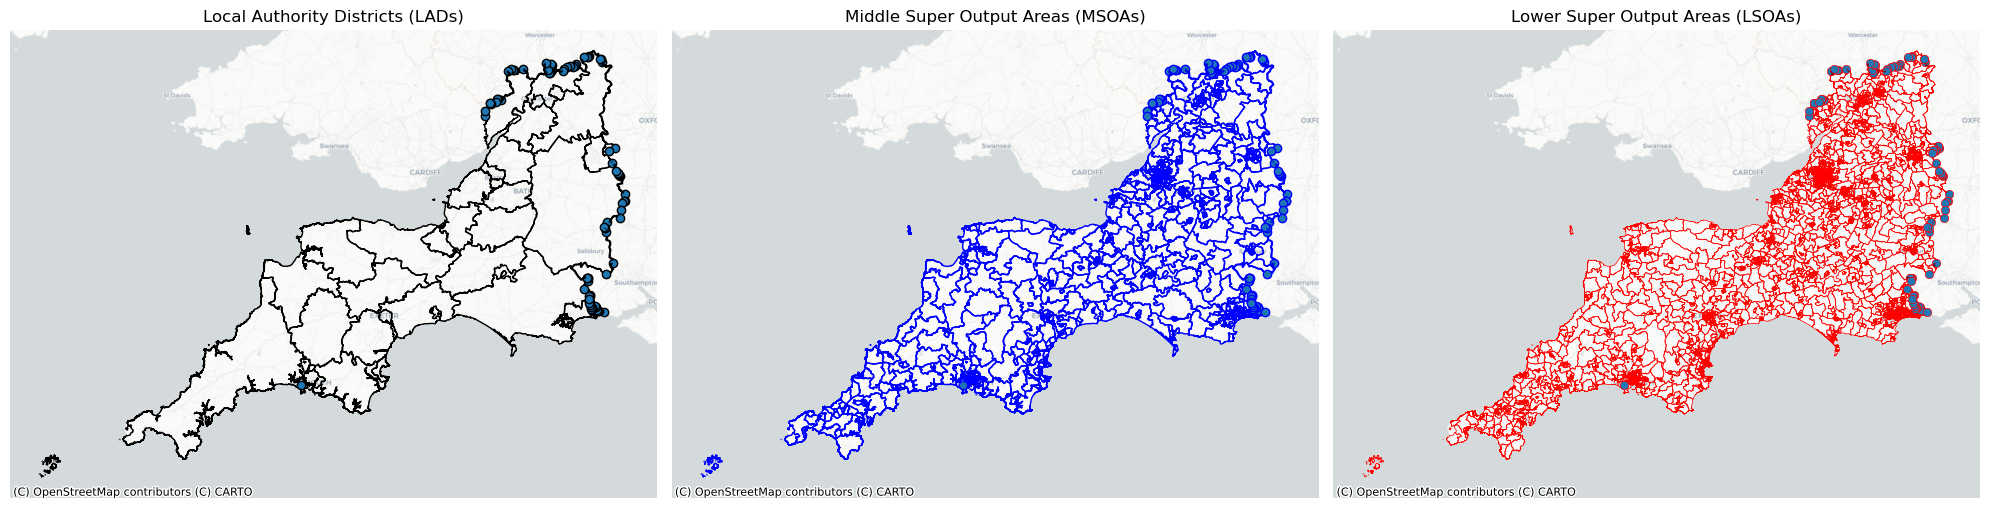

In [4]:
# ------------------------------------------------------------------
# 2. STATIC VISUALIZATION
# ------------------------------------------------------------------
# Note: `contextily` requires data to be in EPSG:3857 projection for basemaps.
print("\nGenerating static overview maps...")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot LAD layer
lad_sw.to_crs(epsg=3857).plot(ax=ax1, edgecolor='black', facecolor='none')
ax1.set_title("Local Authority Districts (LADs)")
cx.add_basemap(ax1, source=cx.providers.CartoDB.Positron)
ax1.axis('off')

# Plot MSOA layer
msoa_sw.to_crs(epsg=3857).plot(ax=ax2, edgecolor='blue', facecolor='none')
ax2.set_title("Middle Super Output Areas (MSOAs)")
cx.add_basemap(ax2, source=cx.providers.CartoDB.Positron)
ax2.axis('off')

# Plot LSOA layer
lsoa_sw.to_crs(epsg=3857).plot(ax=ax3, edgecolor='red', facecolor='none', linewidth=0.5)
ax3.set_title("Lower Super Output Areas (LSOAs)")
cx.add_basemap(ax3, source=cx.providers.CartoDB.Positron)
ax3.axis('off')

plt.tight_layout()
plt.show()



Generating thematic map for Index of Multiple Deprivation...


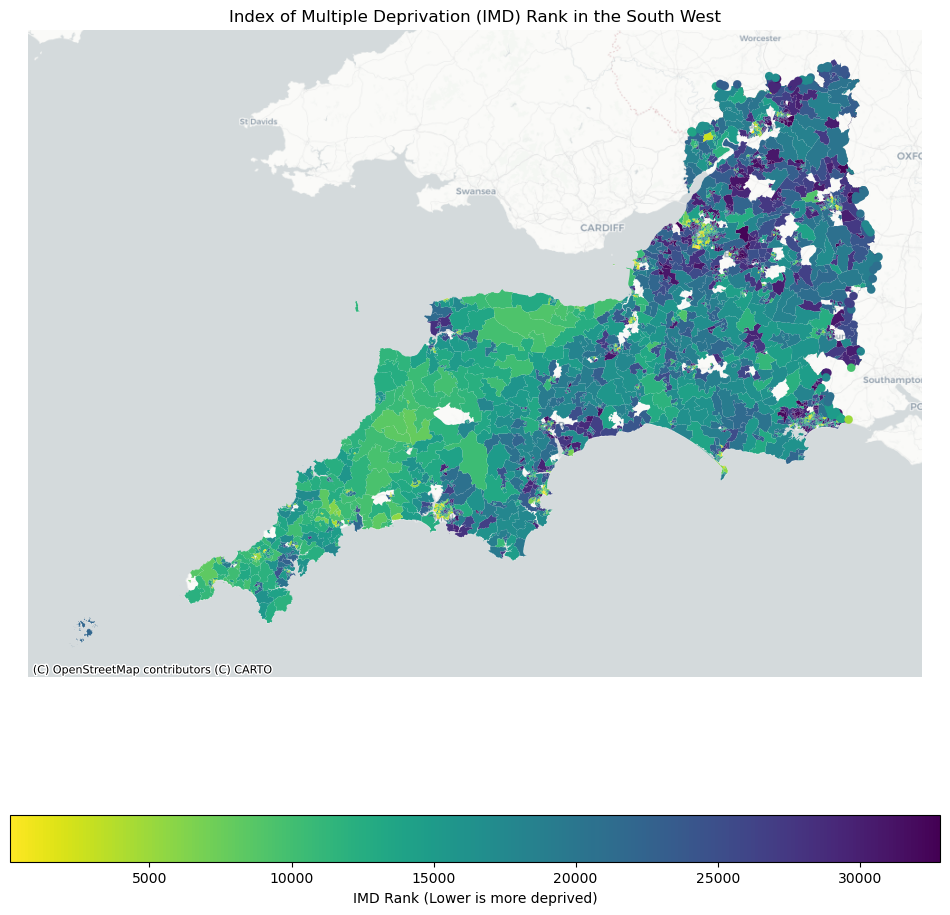

In [5]:
# ------------------------------------------------------------------
# 3. THEMATIC MAP: INDEX OF MULTIPLE DEPRIVATION (IMD)
# ------------------------------------------------------------------
print("\nGenerating thematic map for Index of Multiple Deprivation...")
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lsoa_sw.to_crs(epsg=3857).plot(
    column='imd_rank',
    cmap='viridis_r', # _r reverses the colormap (lower rank = more deprived = darker color)
    linewidth=0.1,
    ax=ax,
    legend=True,
    legend_kwds={'label': "IMD Rank (Lower is more deprived)", 'orientation': "horizontal"}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('Index of Multiple Deprivation (IMD) Rank in the South West')
ax.axis('off')
plt.show()


In [6]:
# ------------------------------------------------------------------
# 4. INTERACTIVE EXPLORATION WITH FOLIUM
# ------------------------------------------------------------------
# Note: In a script, you would save the map to an HTML file.
# In a Jupyter notebook, calling the map variable `m` at the end of
# a cell will display it.
print("\nGenerating interactive Folium map...")

# Find the center of the map for initial view
map_center = lsoa_sw.union_all().centroid.y, lsoa_sw.union_all().centroid.x
# Create a base map
m = folium.Map(location=map_center, zoom_start=8, tiles="CartoDB positron")

# Create an interactive choropleth layer for LSOAs
folium.Choropleth(
    geo_data=lsoa_sw,
    name='LSOA IMD Rank',
    data=lsoa_sw,
    columns=['lsoa', 'imd_rank'],
    key_on='feature.properties.lsoa',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='IMD Rank (Higher is less deprived)',
    highlight=True
).add_to(m)

# Add LAD boundaries for context
folium.GeoJson(
    lad_sw,
    name='LAD Boundaries',
    style_function=lambda x: {'color': 'black', 'weight': 2, 'fillOpacity': 0.0}
).add_to(m)

# Add a layer control panel
folium.LayerControl().add_to(m)



# To view in a notebook, simply have `m` as the last line.
# To save to a file from a script:
m.save("interactive_map_sw.html")
print("✓ Interactive map saved to 'interactive_map_sw.html'")


Generating interactive Folium map...
✓ Interactive map saved to 'interactive_map_sw.html'



Performing mesh test for a specific LAD...
Found 336 LSOAs and 73 MSOAs in Cornwall.


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_3906/3862131575.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


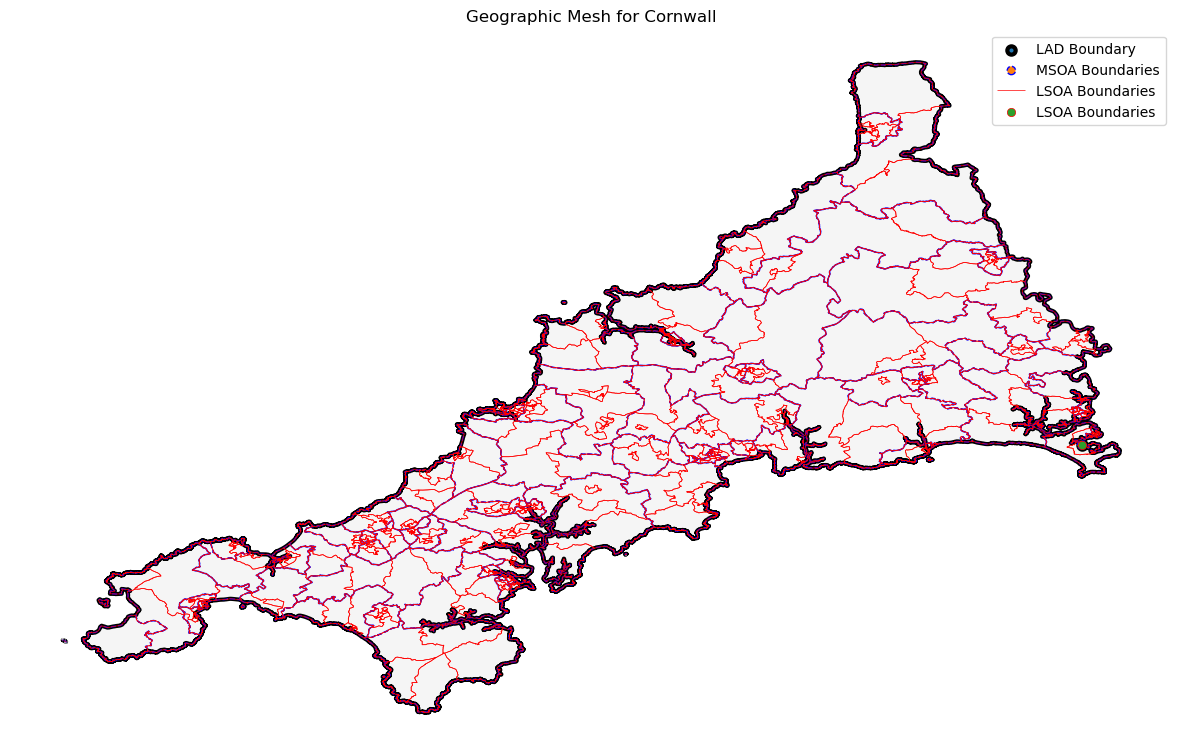

In [7]:
# ------------------------------------------------------------------
# 5. MESH TESTING: OVERLAYING GEOGRAPHIES
# ------------------------------------------------------------------
print("\nPerforming mesh test for a specific LAD...")

# Select a LAD for the detailed view
target_lad_name = 'Cornwall'
target_lad_code = lad_sw[lad_sw['lad_name'] == target_lad_name]['lad'].iloc[0]
target_lad_geom = lad_sw[lad_sw['lad_name'] == target_lad_name]

# Filter MSOAs and LSOAs that fall within the target LAD
msoas_in_lad = msoa_sw[msoa_sw['lad'] == target_lad_code]
lsoas_in_lad = lsoa_sw[lsoa_sw['lad'] == target_lad_code]

print(f"Found {len(lsoas_in_lad)} LSOAs and {len(msoas_in_lad)} MSOAs in {target_lad_name}.")

# Plot the nested layers
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the base LAD boundary
target_lad_geom.plot(ax=ax, edgecolor='black', facecolor='whitesmoke', linewidth=3, label='LAD Boundary')

# Plot the MSOA boundaries within the LAD
msoas_in_lad.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1, linestyle='--', label='MSOA Boundaries')

# Plot the LSOA boundaries within the LAD
lsoas_in_lad.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.5, label='LSOA Boundaries')

ax.set_title(f'Geographic Mesh for {target_lad_name}')
ax.set_aspect('equal')
ax.legend()
plt.axis('off')
plt.show()